In [1]:
from glob import glob
from os.path import join
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from modules.imgur import Client
from templating.post import Post

def to_datetime(x, fmt='%Y:%m:%d %H:%M:%S'):
    return datetime.strptime(x, fmt)

%reload_ext autoreload
%autoreload 2

In [2]:
metadata = pd.read_hdf(Client.metadata_path, 'data')
metadata['album'] = metadata.album.replace('Czech (2019)', 'Czechia (2019)')
metadata['album'] = metadata.album.replace('Home (2020)', 'Tahoe (2020)')
metadata['album'] = metadata.album.replace('Desert (2020)', 'Palm Springs (2020)')
metadata['album'] = metadata.album.replace('Roadtrip (2020)', 'Rocky Mountains (2020)')
metadata['album'] = metadata.album.replace('Italy v2 (2019)', 'Italy 2 (2019)')
metadata.album = metadata.album.str.rsplit(' ', n=1).apply(lambda x: x[0])
metadata['latitude'] = metadata.gps.apply(lambda x: x[0])
metadata['longitude'] = metadata.gps.apply(lambda x: x[1])
metadata = metadata.set_index(['album', 'filename'])
metadata = metadata.sort_values('time_shot_pacific')

# Infer GPS from pings

In [5]:
pings = pd.read_hdf('../../data/pings.hdf', 'data')
pings = pings.sort_index()
pings = pings['2019-08-01':'2020-03-17']
pings = pings[~pings.index.duplicated()]
pings_minutely = pings.resample('T').nearest()
photo_times = metadata.time_shot_pacific.apply(to_datetime)
photo_gps_estimate = pings_minutely.asof(photo_times)
photo_gps_estimate = photo_gps_estimate.set_index(metadata.index)
metadata = metadata.join(photo_gps_estimate, rsuffix='_est')
metadata['latitude_used'] = metadata.latitude.fillna(metadata.latitude_est)
metadata['longitude_used'] = metadata.longitude.fillna(metadata.longitude_est)

# Match semantic locations

In [224]:
def isblank(x):
    if x is None or x == '':
        return True
    elif type(x) == float:
        return np.isnan(x)
    else:
        return False
    
def fix_city(record):
    
    if isblank(record.city):
        
        if not isblank(record.city_district):
            return record.city_district
        
        if not isblank(record.suburb):
            return record.suburb
        
        if not isblank(record.state_district):
            return record.state_district
        
        if not isblank(record.house):
            return record.house
    
    else:
        return record.city

In [302]:
semantic_locations = pd.read_hdf('../../data/semantic_locations.hdf', 'data')
semantic_locations = semantic_locations[~semantic_locations.address.isna()]
semantic_locations = semantic_locations[~(semantic_locations.address=='')]
semantic_locations.loc[semantic_locations.address.apply(lambda x: 'czech' in x.lower()), 'country'] = 'česko'

semantic_locations.loc[semantic_locations.address.apply(lambda x: 'ouarzazate' in x.lower()), 'city'] = 'ouarzazate'
semantic_locations.loc[semantic_locations.address.apply(lambda x: 'marrakesh' in x.lower()), 'city'] = 'marrakesh'

semantic_locations['city'] = semantic_locations.apply(fix_city, axis=1)
named_semantic_locations = semantic_locations[~semantic_locations.name.isna()]

In [303]:
from scipy import spatial
import numpy as np

import math

def haversine(coord1, coord2):
    R = 6372.8 / 1.6  # Earth radius in mi
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    phi1, phi2 = math.radians(lat1), math.radians(lat2) 
    dphi       = math.radians(lat2 - lat1)
    dlambda    = math.radians(lon2 - lon1)
    
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))

def match(photo_positions, semantic_locations):
    location_positions = semantic_locations[['latitude', 'longitude']].values
    tree = spatial.KDTree(location_positions)
    _, idxs = tree.query(photo_positions, p=1)
    distances = np.array([haversine(p1, p2) for p1, p2 in zip(photo_positions, location_positions[idxs])])   
    return distances, idxs

In [304]:
photo_positions = metadata[['latitude_used', 'longitude_used']].values
distances, idxs = match(photo_positions, named_semantic_locations)
photo_semantic_locations = named_semantic_locations.iloc[idxs].set_index(metadata.index)
photo_semantic_locations['distance_to_semantic'] = distances

In [305]:
abbreviations = {
    'france': 'FR', 
    'italia': 'IT', 
    'uk': 'UK', 
    'česko': 'CZ', 
    'deutschland': 'DE',
    'österreich': 'AT', 
    'slovenija': 'SI', 
    'hrvatska': 'HR', 
    'croatia': 'HR', 
    'espanya': 'ES',
    'españa': 'ES', 
    'المغرب': 'MA', 
    'morocco': 'MA',
    'maroc': 'MA', 
    'usa': 'US'
}

def fmt_location(record):
    
    country = abbreviations[record.country]
    city = record.city.title()
    name = record['name'].title()
    
    # only country if unclear
    if record.distance_to_semantic > 15:
        return 'PLACEHOLDER, {:s}'.format(country)
    
    # city/country if reasonable
    if record.distance_to_semantic > 5:
        return '{:s}, {:s}'.format(city, country)
    
    # location if close
    else:
        return '{:s} - {:s}, {:s}'.format(name, city, country)
        

In [311]:
photo_semantic_locations['caption'] = photo_semantic_locations.apply(fmt_location, axis=1)

In [315]:
columns_kept = ['caption', 'id', 'name', 'city', 'state', 'country', 'distance_to_semantic']
metadata = metadata.join(photo_semantic_locations[columns_kept], rsuffix='_semantic')

In [320]:
metadata.to_hdf('./data/metadata_tagged.hdf', 'data')

/Users/Sebi/.virtualenvs/web/lib/python3.6/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['path', 'time_shot', 'time_rendered', 'gps', 'model', 'album_path',
       'album_hash', 'imgur_link', 'imgur_id', 'state', 'city', 'url',
       'address', 'country', 'time_shot_pacific', 'owner', 'caption', 'id',
       'name', 'city_semantic', 'state_semantic', 'country_semantic'],
      dtype='object')]

  encoding=encoding,


In [307]:
def parse_gps(record):
    
    if rec
    

photo_semantic_locations.di

id  \
album           filename                                    
France          IMG_2467.jpg  ChIJgfh6xdhx5kcRTdL6-Nz_qWo   
                IMG_2583.jpg  ChIJoxY3R-Nv5kcRWsRDGBoNIOk   
                IMG_2595.jpg  ChIJoxY3R-Nv5kcRWsRDGBoNIOk   
                IMG_2742.jpg  ChIJ98bX5tht5kcRdbbeksCbBXQ   
                IMG_2762.jpg  ChIJD3uTd9hx5kcR1IQvGfr8dbk   
...                                                   ...   
Rocky Mountains IMG_9729.jpg  ChIJeStJq-ZPUFMRrlIjJ6ufH5U   
                IMG_9731.jpg  ChIJeStJq-ZPUFMRrlIjJ6ufH5U   
                IMG_5128.jpg  ChIJPTg-hZ0aVVMRiEnRXIW3Lt0   
                IMG_5131.jpg  ChIJPTg-hZ0aVVMRiEnRXIW3Lt0   
                IMG_9741.jpg  ChIJB3M8xMJFVVMR-mArhDbEo5w   

                                                                   name  \
album           filename                                                  
France          IMG_2467.jpg                      Terrasse de l'Alcazar   
                IMG_2583.jpg                          Trocadéro Gardens   
                IMG_2595.jpg                          Trocadéro Gardens   
                IMG_2742.jpg          Hôtel Libertel Canal Saint-Martin   
                IMG_2762.jpg                              Louvre Museum   
...                                                                 ...   
Rocky Mountains IMG_9729.jpg                     Refuge Point Trailhead   
                IMG_9731.jpg                     Refuge Point Trailhead   
                IMG_5128.jpg  Idaho Potato Museum & Potato Station Cafe   
                IMG_5131.jpg  Idaho Potato Museum & Potato Station Cafe   
                IMG_9741.jpg                        Walmart Supercenter   

                               latitude   longitude  \
album           filename                              
France          IMG_2467.jpg  48.854624    2.337906   
                IMG_2583.jpg  48.861596    2.289282   
                IMG_2595.jpg  48.861596    2.289282   
                IMG_2742.jpg  48.882326    2.371039   
                IMG_2762.jpg  48.860611    2.337644   
...                                 ...         ...   
Rocky Mountains IMG_9729.jpg  44.868465 -111.357668   
                IMG_9731.jpg  44.868465 -111.357668   
                IMG_5128.jpg  43.189552 -112.343652   
                IMG_5131.jpg  43.189552 -112.343652   
                IMG_9741.jpg  42.910043 -112.463500   

                                                                        address  \
album           filename                                                          
France          IMG_2467.jpg               62 Rue Mazarine\n75006 Paris\nFrance   
                IMG_2583.jpg  Place du Trocadéro et du 11 Novembre\n75016 Pa...   
                IMG_2595.jpg  Place du Trocadéro et du 11 Novembre\n75016 Pa...   
                IMG_2742.jpg             5 Avenue Secrétan\n75019 Paris\nFrance   
                IMG_2762.jpg                 Rue de Rivoli\n75001 Paris\nFrance   
...                                                                         ...   
Rocky Mountains IMG_9729.jpg  7712-7790 Hebgen Lake Rd\nWest Yellowstone, MT...   
                IMG_9731.jpg  7712-7790 Hebgen Lake Rd\nWest Yellowstone, MT...   
                IMG_5128.jpg           130 NW Main St\nBlackfoot, ID 83221\nUSA   
                IMG_5131.jpg           130 NW Main St\nBlackfoot, ID 83221\nUSA   
                IMG_9741.jpg      4240 Yellowstone Ave\nChubbuck, ID 83202\nUSA   

                             house_number  \
album           filename                    
France          IMG_2467.jpg           62   
                IMG_2583.jpg          NaN   
                IMG_2595.jpg          NaN   
                IMG_2742.jpg            5   
                IMG_2762.jpg          NaN   
...                                   ...   
Rocky Mountains IMG_9729.jpg    7712-7790   
                IMG_9731.jpg    7712-7790   
                IMG_5128.jpg          1

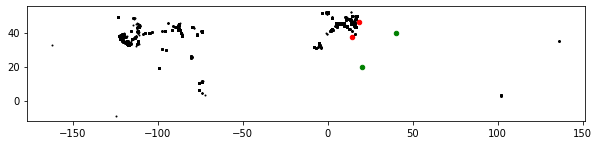

In [74]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(*tree.data.T[::-1], s=1, c='k')
ax.scatter(*tree.data[idx].T[::-1], s=20, c='r')
ax.scatter(*pts.T[::-1], s=20, c='g')
ax.set_aspect(1)

In [ ]:

>>> airports = [(10,10),(20,20),(30,30),(40,40)]
>>> 
>>> tree.query([(21,21)])

In [25]:
metadata

path  \
album           filename                                                          
France          IMG_2467.jpg  /Volumes/bernasek_t5/photos/lightroom/rendered...   
                IMG_2583.jpg  /Volumes/bernasek_t5/photos/lightroom/rendered...   
                IMG_2595.jpg  /Volumes/bernasek_t5/photos/lightroom/rendered...   
                IMG_2742.jpg  /Volumes/bernasek_t5/photos/lightroom/rendered...   
                IMG_2762.jpg  /Volumes/bernasek_t5/photos/lightroom/rendered...   
...                                                                         ...   
Rocky Mountains IMG_9729.jpg  /Volumes/bernasek_t5/photos/lightroom/rendered...   
                IMG_9731.jpg  /Volumes/bernasek_t5/photos/lightroom/rendered...   
                IMG_5128.jpg  /Volumes/bernasek_t5/photos/lightroom/rendered...   
                IMG_5131.jpg  /Volumes/bernasek_t5/photos/lightroom/rendered...   
                IMG_9741.jpg  /Volumes/bernasek_t5/photos/lightroom/rendered...   

                                        time_shot        time_rendered  \
album           filename                                                 
France          IMG_2467.jpg  2019:08:13 07:56:13  2020:04:02 16:07:26   
                IMG_2583.jpg  2019:08:13 20:08:36  2020:04:02 16:07:27   
                IMG_2595.jpg  2019:08:13 20:37:48  2020:04:02 16:07:29   
                IMG_2742.jpg  2019:08:14 12:53:45  2020:04:02 16:07:28   
                IMG_2762.jpg  2019:08:14 13:46:33  2020:04:02 16:07:30   
...                                           ...                  ...   
Rocky Mountains IMG_9729.jpg  2020:03:16 11:42:31  2020:04:02 17:11:03   
                IMG_9731.jpg  2020:03:16 11:44:10  2020:04:02 17:11:05   
                IMG_5128.jpg  2020:03:16 15:10:45  2020:04:02 17:11:05   
                IMG_5131.jpg  2020:03:16 15:16:06  2020:04:02 17:11:07   
                IMG_9741.jpg  2020:03:16 18:37:14  2020:04:02 17:11:08   

                                                                    gps  \
album           filename                                                  
France          IMG_2467.jpg          [48.854591666666664, 2.338019445]   
                IMG_2583.jpg          [48.873311111666666, 2.296480555]   
                IMG_2595.jpg               [48.862, 2.2899277783333334]   
                IMG_2742.jpg    [48.886202778333335, 2.344308333333333]   
                IMG_2762.jpg    [48.88854722166667, 2.3381027783333335]   
...                                                                 ...   
Rocky Mountains IMG_9729.jpg        [44.866180555, -111.35312777833333]   
                IMG_9731.jpg  [44.866772221666665, -111.35411111166667]   
                IMG_5128.jpg       [43.189586111666664, -112.343880555]   
                IMG_5131.jpg  [43.189658333333334, -112.34363611166667]   
                IMG_9741.jpg        [42.566130555, -114.30075833333333]   

                                  model  \
album           filename                  
France          IMG_2467.jpg   iPhone 7   
                IMG_2583.jpg   iPhone 7   
                IMG_2595.jpg   iPhone 7   
                IMG_2742.jpg   iPhone 7   
                IMG_2762.jpg   iPhone 7   
...                                 ...   
Rocky Mountains IMG_9729.jpg   iPhone 7   
                IMG_9731.jpg   iPhone 7   
                IMG_5128.jpg  iPhone SE   
                IMG_5131.jpg  iPhone SE   
                IMG_9741.jpg   iPhone 7   

                                                                     album_path  \
album           filename                                                          
France          IMG_2467.jpg  /Volumes/bernasek_t5/photos/lightroom/rendered...   
                IMG_2583.jpg  /Volumes/bernasek_t5/photos/lightroom/rendered...   
                IMG_2595.jpg  /Volumes/bernasek_t5/photos/lightroom/rendered...   
                IMG_2742.jpg  /Volumes/bernasek_t5/photos/lightroom/rendered...  

In [24]:
semantic_locations.drop_duplicates('id')

,id,name,latitude,longitude,address,house_number,road,city,state,postcode,country,unit,house,city_district,suburb,state_district,po_box,level,island
0,ChIJWRIIZ00tDogRiM95S7fMqPs,Dark Matter Coffee - The Mothership,41.895062,-87.687035,"738 N Western Ave\nChicago, IL 60612\nUSA",738,n western ave,chicago,il,60612,usa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ChIJI8cyylMtDogRV9Ol0LQodyo,Smith Park,41.892786,-87.690283,"738 N Western Ave\nChicago, IL 60612\nUSA",738,n western ave,chicago,il,60612,usa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ChIJxWObbU0tDogRQORdHqxdihg,John Rago Sons Funeral Home & Cremation Services,41.894616,-87.686601,"738 N Western Ave\nChicago, IL 60612\nUSA",738,n western ave,chicago,il,60612,usa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ChIJK3cLPE0tDogR426ptRCHXy0,Bacci Pizzeria,41.895553,-87.686072,"738 N Western Ave\nChicago, IL 60612\nUSA",738,n western ave,chicago,il,60612,usa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ChIJt6zCu1ItDogRlgllKzSqGGE,CVS Pharmacy - Photo,41.895517,-87.687610,"738 N Western Ave\nChicago, IL 60612\nUSA",738,n western ave,chicago,il,60612,usa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68590,ChIJ5dP0kJDRD4gRL6HaLtVuKHA,None,41.988549,-87.668671,"5739 N Clark St\nChicago, IL 60660\nUSA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68591,ChIJh8B65o_RD4gRMb6uG14Dxe0,Windy Knitty,41.984812,-87.668826,"5739 N Clark St\nChicago, IL 60660\nUSA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68592,ChIJBTnJH5DRD4gRtTOJyjlDGT8,Clark & Hollywood,41.985357,-87.669080,"5739 N Clark St\nChicago, IL 60660\nUSA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68593,ChIJYXOUIpDRD4gR9xCYUWEGinE,Be Yoga Andersonville,41.985838,-87.669043,"5739 N Clark St\nChicago, IL 60660\nUSA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
photo_gps_estimate.head()

,altitude,latitude,longitude,owner
time_shot_pacific,,,,
2019-08-12 22:56:13,29.0,48.854613,2.338069,SMB
2019-08-13 11:08:36,63.0,48.861710,2.289706,CMB
2019-08-13 11:37:48,63.0,48.861710,2.289706,CMB
2019-08-14 03:53:45,29.0,48.854632,2.338150,SMB
2019-08-14 04:46:33,100.0,48.889165,2.338302,CMB


In [155]:
columns = ['est_altitude', 'est_latitude', 'est_longitude', 'est_source']
metadata[columns] = photo_gps_estimate

In [156]:
metadata

path  \
album           filename                                                          
France          IMG_2467.jpg  /Volumes/bernasek_t5/photos/lightroom/rendered...   
                IMG_2583.jpg  /Volumes/bernasek_t5/photos/lightroom/rendered...   
                IMG_2595.jpg  /Volumes/bernasek_t5/photos/lightroom/rendered...   
                IMG_2742.jpg  /Volumes/bernasek_t5/photos/lightroom/rendered...   
                IMG_2762.jpg  /Volumes/bernasek_t5/photos/lightroom/rendered...   
...                                                                         ...   
Rocky Mountains IMG_9729.jpg  /Volumes/bernasek_t5/photos/lightroom/rendered...   
                IMG_9731.jpg  /Volumes/bernasek_t5/photos/lightroom/rendered...   
                IMG_5128.jpg  /Volumes/bernasek_t5/photos/lightroom/rendered...   
                IMG_5131.jpg  /Volumes/bernasek_t5/photos/lightroom/rendered...   
                IMG_9741.jpg  /Volumes/bernasek_t5/photos/lightroom/rendered...   

                                        time_shot        time_rendered  \
album           filename                                                 
France          IMG_2467.jpg  2019:08:13 07:56:13  2020:04:02 16:07:26   
                IMG_2583.jpg  2019:08:13 20:08:36  2020:04:02 16:07:27   
                IMG_2595.jpg  2019:08:13 20:37:48  2020:04:02 16:07:29   
                IMG_2742.jpg  2019:08:14 12:53:45  2020:04:02 16:07:28   
                IMG_2762.jpg  2019:08:14 13:46:33  2020:04:02 16:07:30   
...                                           ...                  ...   
Rocky Mountains IMG_9729.jpg  2020:03:16 11:42:31  2020:04:02 17:11:03   
                IMG_9731.jpg  2020:03:16 11:44:10  2020:04:02 17:11:05   
                IMG_5128.jpg  2020:03:16 15:10:45  2020:04:02 17:11:05   
                IMG_5131.jpg  2020:03:16 15:16:06  2020:04:02 17:11:07   
                IMG_9741.jpg  2020:03:16 18:37:14  2020:04:02 17:11:08   

                                                                    gps  \
album           filename                                                  
France          IMG_2467.jpg          [48.854591666666664, 2.338019445]   
                IMG_2583.jpg          [48.873311111666666, 2.296480555]   
                IMG_2595.jpg               [48.862, 2.2899277783333334]   
                IMG_2742.jpg    [48.886202778333335, 2.344308333333333]   
                IMG_2762.jpg    [48.88854722166667, 2.3381027783333335]   
...                                                                 ...   
Rocky Mountains IMG_9729.jpg        [44.866180555, -111.35312777833333]   
                IMG_9731.jpg  [44.866772221666665, -111.35411111166667]   
                IMG_5128.jpg       [43.189586111666664, -112.343880555]   
                IMG_5131.jpg  [43.189658333333334, -112.34363611166667]   
                IMG_9741.jpg        [42.566130555, -114.30075833333333]   

                                  model  \
album           filename                  
France          IMG_2467.jpg   iPhone 7   
                IMG_2583.jpg   iPhone 7   
                IMG_2595.jpg   iPhone 7   
                IMG_2742.jpg   iPhone 7   
                IMG_2762.jpg   iPhone 7   
...                                 ...   
Rocky Mountains IMG_9729.jpg   iPhone 7   
                IMG_9731.jpg   iPhone 7   
                IMG_5128.jpg  iPhone SE   
                IMG_5131.jpg  iPhone SE   
                IMG_9741.jpg   iPhone 7   

                                                                     album_path  \
album           filename                                                          
France          IMG_2467.jpg  /Volumes/bernasek_t5/photos/lightroom/rendered...   
                IMG_2583.jpg  /Volumes/bernasek_t5/photos/lightroom/rendered...   
                IMG_2595.jpg  /Volumes/bernasek_t5/photos/lightroom/rendered...   
                IMG_2742.jpg  /Volumes/bernasek_t5/photos/lightroom/rendered...  

In [117]:
times.iloc[0]
pings_minutely.loc[]

KeyError: Timestamp('2019-08-17 05:58:42')

In [23]:
s = df.iloc[df.index.get_loc(dt, method='nearest')]

TypeError: '>' not supported between instances of 'float' and 'datetime.datetime'

datetime.datetime(2019, 1, 1, 0, 0)

In [14]:
from datetime import datetime

In [11]:
datetime.strptime()

# GoogleMap API

In [59]:
import googlemaps
from datetime import datetime

gmaps = googlemaps.Client(key=key)

In [61]:
responses = {}
for idx, record in metadata.iterrows():
    if None in record.gps:
        continue
    
    response = gmaps.reverse_geocode(record.gps)
    responses[record.path] = response

In [63]:
import json

# with open('./location_data.json', 'w') as file:
#     json.dump(responses, file)

# Parse responses

In [1]:
import json
with open('./data/location_data.json', 'r') as file:
    responses = json.load(file)

In [6]:
import pandas as pd

def parse_response(url, response):
    
    missing_keys = [
        'country',
        'administrative_area_level_1', 
        'administrative_area_level_2', 
        'administrative_area_level_3', 
        'administrative_area_level_4',
        'locality',
        'route']

    acquired = {'url': url}
    for entry in response:
        for component in entry['address_components']:
            for i, key in enumerate(missing_keys):
                if key in component['types']:        
                    key = missing_keys.pop(i)                
                    acquired[key] = component['short_name']
                    
    return acquired

def fmt_address(record):
    
    if record.locality is None:
        caption = record.country
    
    elif record.administrative_area_level_1 is None:
        caption = '{:s}, {:s}'.format(record.locality, record.country)
        
    else:
        caption = '{:s}, {:s}'.format(record.locality, record.administrative_area_level_1)
            
    return caption

In [7]:
df = pd.DataFrame([parse_response(url, response) for url, response in responses.items()])
df[df.isna()] = None
df['address'] = df.apply(fmt_address, axis=1)
df['city'] = df.locality
df['state'] = df.administrative_area_level_1

In [52]:
metadata = pd.merge(metadata, df[['url', 'address', 'country', 'state', 'city']], how='left', left_on='path', right_on='url')

# Shift timestamps and interpolate locations

In [131]:
from datetime import datetime, timedelta

country_tshifts = {'IT': 9, 'FR': 9, 'GB': 8, 'CZ': 9, 'DE': 9, 'AT': 9, 'SI': 9, 'HR': 9, 'ES': 9, 'MA': 8}
state_tshifts = {'CA': 0, 'NV': 0, 'UT': 1, 'WY': 1, 'MT': 1, 'ID': 1}

def correct_time(record, fmt='%Y:%m:%d %H:%M:%S'):
    time_shot = datetime.strptime(record.time_shot, fmt)
    if record.country == 'US':
        dt = timedelta(hours=state_tshifts[record.state])
    else:
        
        if record.country not in country_tshifts.keys():
            print(record)
            raise ValueError
        
        dt = timedelta(hours=country_tshifts[record.country])
    us_time_shot = time_shot - dt
    return us_time_shot.strftime(fmt)
    
def get_us_time(record):
    if None in record.gps:
        return record.time_shot
    else:
        us_time_shot = correct_time(record)
        return us_time_shot

In [ ]:
metadata['time_shot_pacific'] = metadata.apply(get_us_time, axis=1)
metadata = metadata.sort_values(by='time_shot_pacific')

In [171]:
import numpy as np
tagged, untagged = metadata[metadata.geotagged], metadata[~metadata.geotagged]
idxs = np.searchsorted(tagged.time_shot_pacific.values, untagged.time_shot_pacific.values)
for attr in ['city', 'state', 'country', 'address']:
    metadata.loc[untagged.index, attr] = tagged.iloc[idxs][attr].values

In [190]:
from exif import Image as ExifImage
from iptcinfo3 import IPTCInfo

def to_dd(d, m, s):
    return d + (m/60) + (s/3600)

def localize(timestamp, tz, fmt='%Y:%m:%d %H:%M:%S'):
    shifts = {'pst': 0, 'mst': 1, 'gmt': 8, 'cet': 9}
    t = datetime.strptime(timestamp, fmt)
    dt = timedelta(hours=shifts[tz])
    t_localized = t - dt
    return t_localized.strftime(fmt)

def parse(filepath):

    with open(filepath, 'rb') as file:
        exif = ExifImage(file)
    time_shot_local = exif.datetime_original
        
    iptc = IPTCInfo(filepath)
    keywords = [str(x, 'utf-8') for x in iptc['keywords']]
    for tz in ['pst', 'mst', 'gmt', 'cet']:
        if tz in keywords:
            break
    time_shot_pacific = localize(time_shot_local, tz)
    
    try:
        gps = [to_dd(*exif.gps_latitude), -to_dd(*exif.gps_longitude)]
    except:
        gps = None
    
    return {
        'url': filepath,
        'time_local': time_shot_local,
        'time_pacific': time_shot_pacific,        
        'gps': gps}

In [201]:
import warnings
warnings.simplefilter('ignore')

dirpaths = [
    '/Volumes/bernasek_t5/photos/original/phone',
    '/Volumes/bernasek_t5/photos/original/xtina_phone'
] 

records = []
for dirpath in dirpaths:
    for filepath in glob(join(dirpath, '*.JPG')):
        try:
            record = parse(filepath)
            records.append(record)
        except:
            continue

In [203]:
import pandas as pd
df = pd.DataFrame(records)
df.to_hdf('./data/phone.hdf', 'data')

In [210]:
df = df.sort_values(by='time_pacific')

In [212]:
jpeg_data = df
jpeg_data = jpeg_data[jpeg_data.gps.apply(lambda x: type(x)==list)]

In [234]:
jpeg_data[['latitude','longitude']] = pd.DataFrame(jpeg_data.gps.values.tolist(), index=jpeg_data.index)

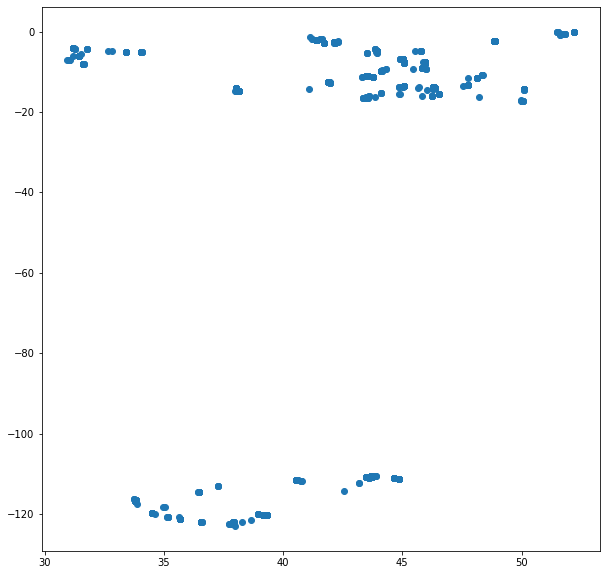

In [239]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(jpeg_data.latitude, jpeg_data.longitude)